In [2]:
import numpy as np
from keras.datasets import mnist 
import random

##EXPERIMENT ON MNIST DATASET

In [3]:
# the data, shuffled and split between train and test sets 
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("Number of training examples :", X_train.shape[0], "and each image is of shape (%d, %d)"%(X_train.shape[1], X_train.shape[2]))
print("Number of training examples :", X_test.shape[0], "and each image is of shape (%d, %d)"%(X_test.shape[1], X_test.shape[2]))

11501568/11490434 [==============================] - 0s 0us/step
Number of training examples : 60000 and each image is of shape (28, 28)
Number of training examples : 10000 and each image is of shape (28, 28)


In [4]:
# if you observe the input shape its 2 dimensional vector
# for each image we have a (28*28) vector
# we will convert the (28*28) vector into single dimensional vector of 1 * 784 

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

# after converting the input images from 3d to 2d vectors

print("Number of training examples :", X_train.shape[0], "and each image is of shape (%d)"%(X_train.shape[1]))
print("Number of training examples :", X_test.shape[0], "and each image is of shape (%d)"%(X_test.shape[1]))

Number of training examples : 60000 and each image is of shape (784)
Number of training examples : 10000 and each image is of shape (784)


In [5]:
X_train = X_train/255
X_test = X_test/255


In [6]:
from keras.utils import np_utils
# here we are having a class number for each image
print("Class label of first image :", y_train[0])


Y_train = np_utils.to_categorical(y_train, 10) 
Y_test = np_utils.to_categorical(y_test, 10)

Class label of first image : 5


In [ ]:
#function to normalize the output frm hidden layer
def normalize(array):
  minimun = array.max()
  maximum = array.min()
  array = (array - minimun) / (maximum - minimun)
  return array

#function to avoid exploding gradient
def gradient_clipping(weight,threshold):
  weight_flatten = weight.flatten()
  sums =   sum([i ** 2 for i in weight_flatten])
  return (weight/ sums) * threshold 

#function to convert softmax output into one hot encoding
def label(z):
  a = np.argmax(z)
  b = np.zeros(10)
  b[a] = 1
  return b

#function to calculate accuracy
def accuracy(z , cross):
  pred_index = np.argmax(z)
  true_index = np.argmax(cross)
  if pred_index == true_index:
    return 1
  else:
    return 0  


#function to generate confusion matrix
def confusion_matrix(true_y,pred_y):
  classes = sorted(list(set(true_y)))
  size = len(list(set(true_y)))
  c = np.zeros([size, size],dtype=int)
  for i in range(size):
    for j in range(size):
      for k in range(len(true_y)):
        if true_y[k] == classes[i] and pred_y[k]  == classes[j]:
          c[i][j] += 1

  return c 
  
#funcrion to calculate f1_score
def fl_score(c):
  e = 0.001 #just to make sure that denominator is not zero
  f1 = []
  for i in range(10):
    a = sum(c[i])
    b = sum(c[:, i])
    d = c[i][i]
    presion = d/(a + e)
    recall = d/(b +e)

    f1_score_each_class = 2*((presion*recall)/((presion+recall) + e))
    f1.append(f1_score_each_class)

    return np.mean(f1)      

In [ ]:
#total number of epoch to run
epoch = 20

# initial parameter for 1st layer activation
k1 , k2 = 0.2 , 0.4 

# initial parameter for 2nd layer activation
k3 , k4 = 0.5 , 0.7

#learning rate for weight update and activation parameter update
alpha , beta = 0.000001 , 0.000001

# weights and biases initilization for hidden layers
weight1 = np.random.normal(0, 1, (784, 392))
weight2 = np.random.normal(0, 1, (392, 196))
weight3 = np.random.normal(0, 1, (196, 10))
baise1 = np.random.normal(0, 1, (392))
baise2 = np.random.normal(0, 1, (196))
baise3 = np.random.normal(0, 1, (10))

#collecting losses and accuracy for train and test data at each epochs
Train_losses , Train_accuracy = list() , list()
Test_losses , Test_accuracy = list() , list()
k1_new , k2_new , k3_new , k4_new = list() , list() , list() , list()
test_f1_score = []

for i in range(epoch):

  #suffling train data 
  suffle = np.array([random.randrange(1, 50000, 100) for i in range(1000)])

  data_loss = []
  data_accuracy = []

  #for j in suffle:
  for j in suffle:  
    
    #training on train data
    input  =X_train[j]

    #first hidden Layer
    result1 = np.dot(input.T,weight1)
    result1 = result1 + baise1
    result1 = result1.T
    result1_active  = k1 + k2 * result1
    result1_active = normalize(result1_active)

    #second hidden Layer
    result2 = np.dot(result1_active.T,weight2)
    result2 = result2 + baise2
    result2 = result2.T
    result2_active = k1 + k2 * result2
    result2_active = normalize(result2_active)

    #third dense  Layer softmax
    result3 = np.dot(result2_active.T,weight3)
    result3 = result3 + baise3
    result3_active = result3.T
    result3_active = normalize(result3_active)

    #applying Softmax
    result3_active = np.array(result3_active, dtype=np.float128)
    result3_active = np.exp(result3_active)
    row_sums = result3_active.sum(axis=0)
    z = result3_active / row_sums

    #calculating losses
    cross = Y_train[j]
    loss = -cross * np.log10(z)

    #calculating total losses for each data point
    tot_loss  = loss.sum(axis=0)
    data_loss.append(tot_loss)

    ##accuracy
    res = accuracy(z , cross)
    data_accuracy.append(res)


    #--------------------Backpropogation-------------------------- 
    #gradient from softmax
    dy =  -(1- z) * cross

    #updating 3rd weight
    t =alpha *  result2_active ## alpha = 0.2
    t  = np.dot(np.array([t]).T,np.array([dy.T]))
    weight3 = weight3 - t
    weight3 = gradient_clipping(weight3,2)

    #updating 3rd baise
    baise3 = baise3 - alpha * dy

    #updating 2nd activation
    e  = np.dot(np.array([dy.T]),weight3.T)
    f = e.sum(axis=1)
    k3 = k3 - beta * f # alpha = 0.5

    e  = np.dot(np.array([dy.T]),weight3.T)
    f = result2 * e
    f = f.sum(axis=1)
    k4 = k4 - beta * f # alpha = 0.5

    #updating 2nd weight
    b  = np.dot(weight3,np.array([dy]).T)
    c = b.T
    t = np.dot(np.array([result1_active]).T,c)*k4
    weight2 = weight2 - alpha * t
    weight2 = gradient_clipping(weight2,2)

    #updating 2nd baise
    baise2 = baise2 - alpha * c * k4
    baise2 = baise2.flatten()

    #updating 1st activation
    e = np.dot(weight2,weight3)
    f = np.dot(e,dy)
    g = k4 * result1*f
    h = np.sum(g)
    k2 = k2 - beta* h

    g = k4 *f
    h = np.sum(g)
    k1  = k1 - beta* h
    
    #updating 1st weight
    e = np.dot(weight2,weight3)
    f = np.dot(e,dy)
    g = k4 * k2*f
    h = np.dot(np.array([input]).T,np.array([g]))
    weight1 = weight1 - alpha * h
    weight1 = gradient_clipping(weight1,2)

    #updating 1st baise
    baise1 = baise1 - alpha * f * k4 * k2


  if i % 5 == 0:
    alpha = alpha/2
    beta = beta/2

  #calculating mean loss at each epoch
  los = sum(data_loss)/1000
  Train_losses.append(los)

  #calculating mean accuracy at each epoch
  los = sum(data_accuracy)/1000
  Train_accuracy.append(los)

  #appending updated activation parameter
  k1_new.append(k1)
  k2_new.append(k2)
  k3_new.append(k3)
  k4_new.append(k4)

#----------------------------------TESTING ON TEST DATAPOINTS --------------------------------
  pred = []
  data_loss_test = []
  data_accuracy_test = []
  for j in range(1000):  
    
    #training on train data
    input  =X_test[j]

    #first hidden Layer
    result1 = np.dot(input.T,weight1)
    result1 = result1 + baise1
    result1 = result1.T
    result1_active  = k1 + k2 * result1
    result1_active = normalize(result1_active)

    #second hidden Layer
    result2 = np.dot(result1_active.T,weight2)
    result2 = result2 + baise2
    result2 = result2.T
    result2_active = k1 + k2 * result2
    result2_active = normalize(result2_active)

    #third dense  Layer softmax
    result3 = np.dot(result2_active.T,weight3)
    result3 = result3 + baise3
    result3_active = result3.T
    result3_active = normalize(result3_active)

    #applying Softmax
    result3_active = np.array(result3_active, dtype=np.float128)
    result3_active = np.exp(result3_active)
    row_sums = result3_active.sum(axis=0)
    z = result3_active / row_sums

    p = label(z)
    pred.append(p)

    #calculating losses
    cross = Y_test[j]
    loss = -cross * np.log10(z)

    #calculating total losses for each data point
    tot_loss  = loss.sum(axis=0)
    data_loss_test.append(tot_loss)

    ##accuracy
    res = accuracy(z , cross)
    data_accuracy_test.append(res)


  #calculating mean loss at each epoch
  los = sum(data_loss_test)/1000
  Test_losses.append(los)

  #calculating mean accuracy at each epoch
  los = sum(data_accuracy_test)/1000
  Test_accuracy.append(los)  

  #calculating f1_score at each epoch

  real = []
  for i in range(1000):
    real.append(Y_test[i])


  a , b = list() , list()
  for i in range(1000):
    pc = np.argmax(pred[i])
    t = np.argmax(real[i])
    a.append(pc)
    b.append(t)

  c = confusion_matrix(b,a)  

  test_f1 = fl_score(c)
  test_f1_score.append(test_f1)  

#Plot of Epoch Number Vs Train loss and Test loss

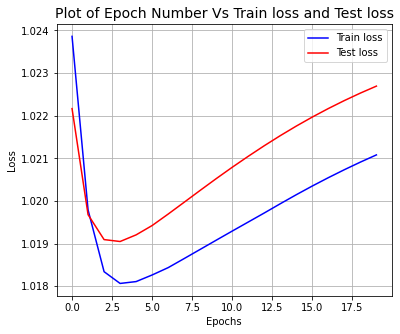

In [ ]:
epoch = np.arange(20)
plt.figure( figsize=(6,5))
plt.grid()
plt.plot(epoch,Train_losses,color='blue')
plt.plot(epoch,Test_losses,color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Plot of Epoch Number Vs Train loss and Test loss',fontsize = 14)
plt.legend(['Train loss','Test loss'])
plt.show()

#Plot of Epoch Number Vs Train_accuracy and Test_accuracy

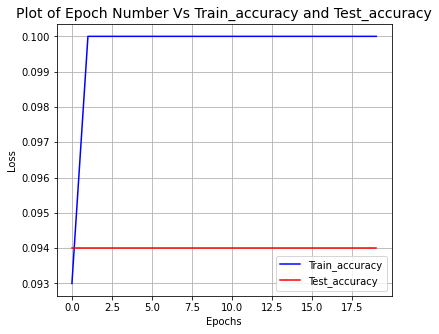

In [ ]:
epoch = np.arange(20)
plt.figure( figsize=(6,5))
plt.grid()
plt.plot(epoch,Train_accuracy,color='blue')
plt.plot(epoch,Test_accuracy,color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Plot of Epoch Number Vs Train_accuracy and Test_accuracy',fontsize = 14)
plt.legend(['Train_accuracy','Test_accuracy'])
plt.show()

#Plot of Epoch Number Vs k1 ,k2, k3 and k4

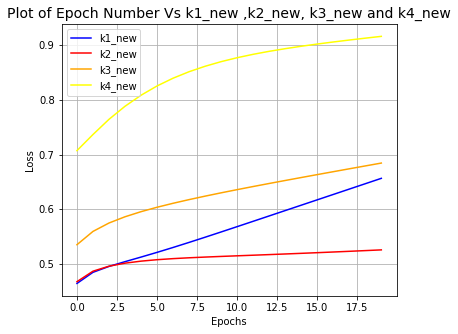

In [ ]:
epoch = np.arange(20)
plt.figure( figsize=(6,5))
plt.grid()
plt.plot(epoch,k1_new,color='blue')
plt.plot(epoch,k2_new,color='red')
plt.plot(epoch,k3_new,color='orange')
plt.plot(epoch,k4_new,color='yellow')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Plot of Epoch Number Vs k1_new ,k2_new, k3_new and k4_new',fontsize = 14)
plt.legend(['k1_new','k2_new','k3_new','k4_new'])
plt.show()